In [824]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gc


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [825]:
ls

data/  forexeda.ipynb  getdata/  models/  README.md  resources/


In [826]:
df = pd.read_pickle('data/EUR_USD_M1')
df.set_index('time', inplace=True)
df.shape
df_columns = list(df.columns)

In [827]:
df.head()

volume    close     high      low     open  complete
time                                                                     
2005-01-02 18:29:00       1 1.356000 1.356000 1.356000 1.356000      True
2005-01-02 18:38:00       1 1.356000 1.356000 1.356000 1.356000      True
2005-01-02 18:51:00       1 1.356700 1.356700 1.356700 1.356700      True
2005-01-02 18:52:00       1 1.356500 1.356500 1.356500 1.356500      True
2005-01-02 18:55:00       1 1.356800 1.356800 1.356800 1.356800      True

In [828]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4644072 entries, 2005-01-02 18:29:00 to 2017-09-05 03:34:00
Data columns (total 6 columns):
volume      int64
close       float64
high        float64
low         float64
open        float64
complete    bool
dtypes: bool(1), float64(4), int64(1)
memory usage: 217.0 MB


In [829]:
def plot_price(price_series, figtitle):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(price_series)
    ax.set_title(figtitle)    

In [830]:
df = df.loc[datetime(2016,4,1):datetime(2016,4,22)]
df.shape

(20597, 6)

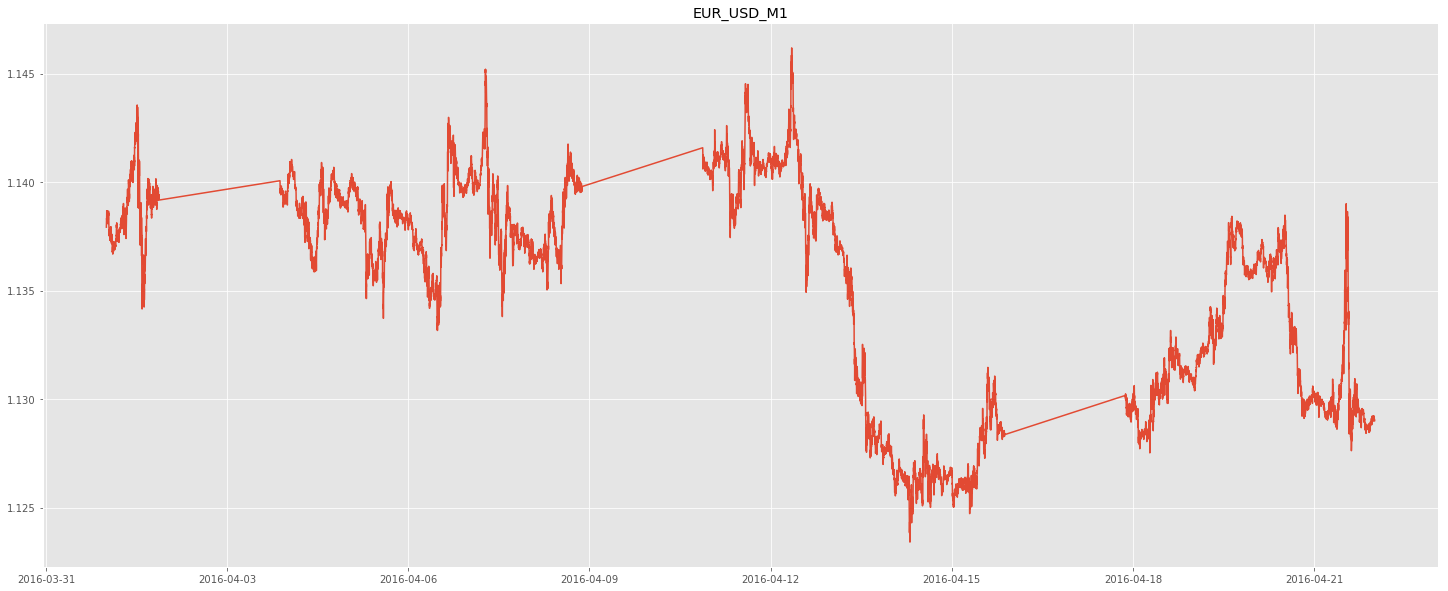

In [831]:
plot_price(df['close'], 'EUR_USD_M1')

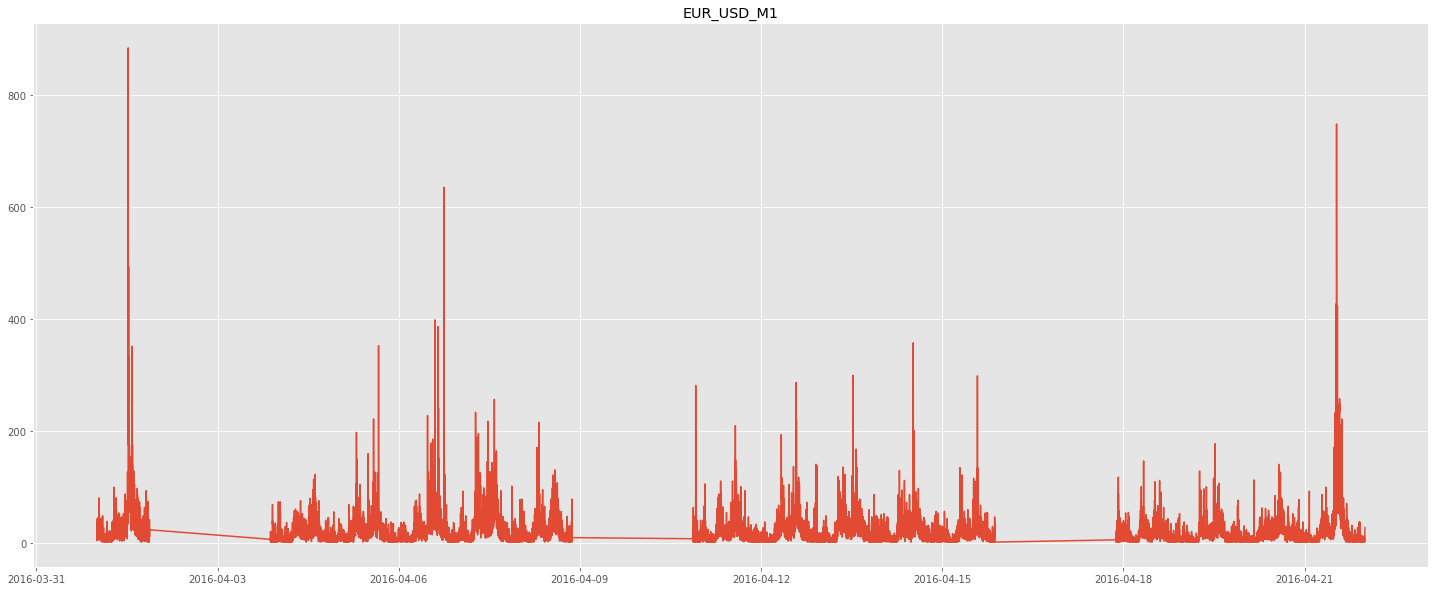

In [832]:
plot_price(df['volume'], 'EUR_USD_M1')

In [833]:
close_prices = df['close'].values.reshape(-1,1)
close_prices.shape

(20597, 1)

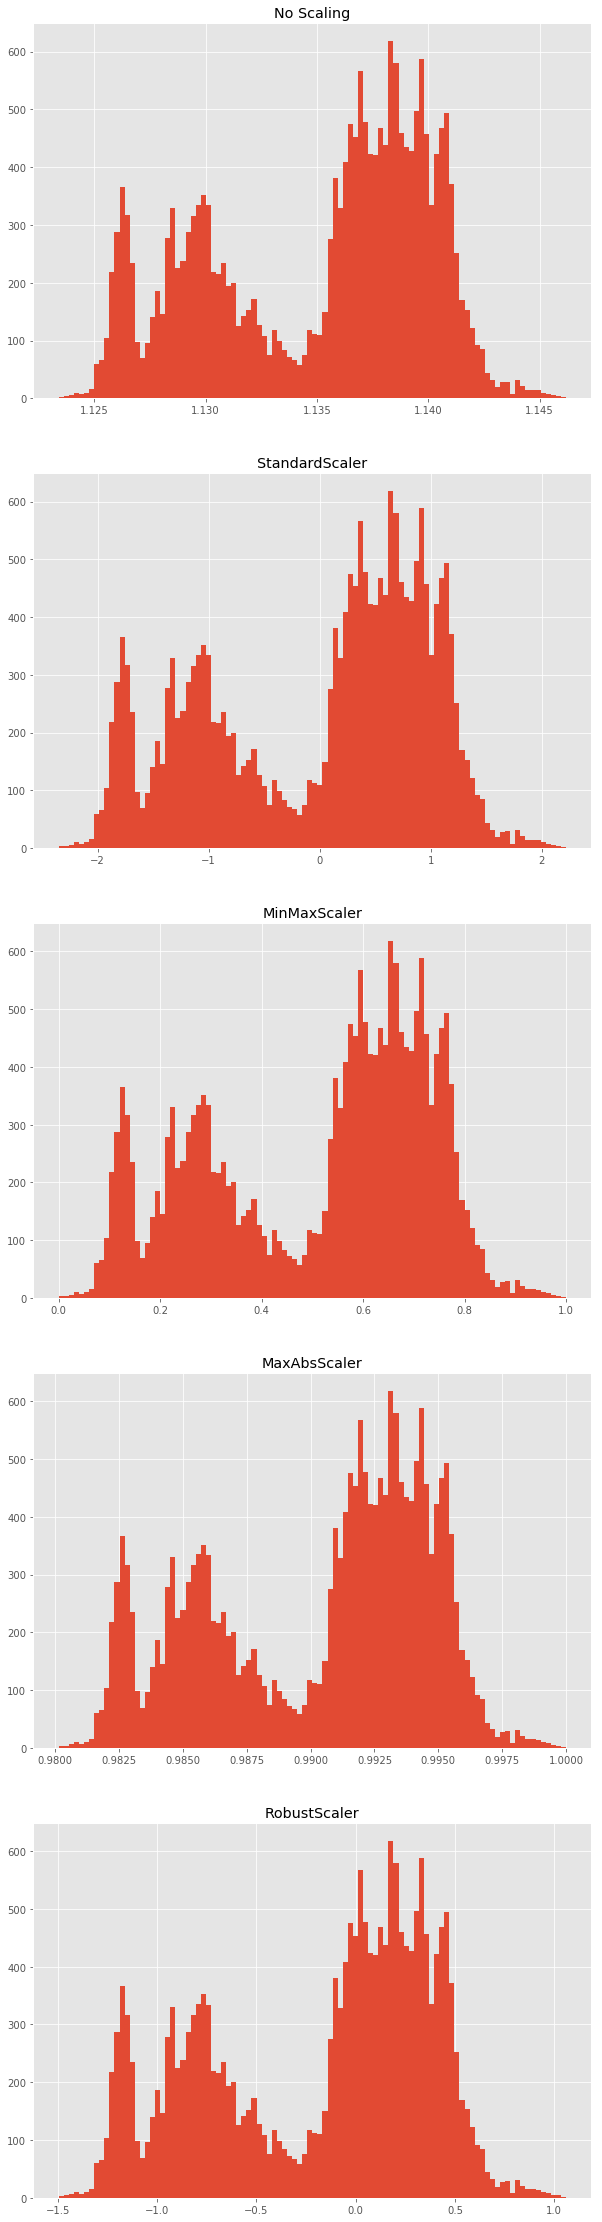

In [834]:
sc, mm, ma, rs = StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()
scalers = [sc, mm, ma, rs]
fig, axes = plt.subplots(len(scalers)+1, 1, figsize=(10,40))
for i, ax in enumerate(axes.reshape(-1)):
    if i == 0:
        ax.hist(close_prices, bins=100)
        ax.set_title('No Scaling')
    else:
        scale = scalers[i-1]
        close_prices_scaled = scale.fit_transform(close_prices)
        ax.hist(close_prices_scaled, bins=100)
        ax.set_title(scale.__class__.__name__)

In [835]:
df_values.shape

(30606, 5)

In [836]:
df.columns

Index(['volume', 'close', 'high', 'low', 'open', 'complete'], dtype='object')

# Add Target for Classification (Up / Down)

target of i day is the np.sign((open i+d) - (open i))

Exponentially smooth data before calculating features?

In [837]:
# df = pd.read_pickle('data/EUR_USD_H12')
# df.set_index('time', inplace=True)
# df.shape
# df.head()

In [838]:
def up_down(row):
    if row >= 0:
        return 1
    elif row < 0:
        return 0
    else:
        None

In [839]:
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['ari_returns'] = (df['close'] / df['close'].shift(1)) - 1
df['log_returns_shifted'] = np.log(df['close'].shift(-1) / df['close'])
df['target_label_direction'] = df['log_returns'].apply(up_down)
df['target_label_direction_shifted'] = df['log_returns_shifted'].apply(up_down)

In [840]:
df.head(100)

volume    close     high      low     open  complete  \
time                                                                        
2016-04-01 00:00:00      29 1.137920 1.137960 1.137680 1.137860      True   
2016-04-01 00:01:00      16 1.138030 1.138030 1.137800 1.137880      True   
2016-04-01 00:02:00      11 1.138180 1.138210 1.138040 1.138060      True   
2016-04-01 00:03:00      15 1.138180 1.138230 1.138130 1.138160      True   
2016-04-01 00:04:00       8 1.138180 1.138200 1.138140 1.138180      True   
2016-04-01 00:05:00       4 1.138320 1.138320 1.138220 1.138220      True   
2016-04-01 00:06:00      14 1.138300 1.138300 1.138220 1.138280      True   
2016-04-01 00:07:00      10 1.138280 1.138340 1.138270 1.138340      True   
2016-04-01 00:08:00      42 1.138650 1.138720 1.138320 1.138320      True   
2016-04-01 00:09:00      12 1.138680 1.138720 1.138620 1.138620      True   
2016-04-01 00:10:00      14 1.138540 1.138660 1.138500 1.138660      True   
2016-04-01 00:11:00       6 1.138520 1.138570 1.138480 1.138570      True   
2016-04-01 00:12:00       8 1.138570 1.138580 1.138480 1.138490      True   
2016-04-01 00:13:00      31 1.138680 1.138860 1.138540 1.138540      True   
2016-04-01 00:14:00      13 1.138570 1.138720 1.138570 1.138720      True   
2016-04-01 00:15:00      18 1.138620 1.138660 1.138570 1.138600      True   
2016-04-01 00:16:00      24 1.138420 1.138600 1.138380 1.138600      True   
2016-04-01 00:17:00      17 1.138280 1.138460 1.138260 1.138440      True   
2016-04-01 00:18:00       9 1.138270 1.138400 1.138270 1.138300      True   
2016-04-01 00:19:00      15 1.138500 1.138500 1.138300 1.138300      True   
2016-04-01 00:20:00      23 1.138480 1.138600 1.138440 1.138540      True   
2016-04-01 00:21:00      13 1.138320 1.138480 1.138290 1.138480      True   
2016-04-01 00:22:00       6 1.138320 1.138370 1.138320 1.138350      True   
2016-04-01 00:23:00      11 1.138340 1.138380 1.138280 1.138340      True   
2016-04-01 00:24:00      15 1.138420 1.138440 1.138280 1.138340      True   
2016-04-01 00:25:00      13 1.138370 1.138520 1.138370 1.138460      True   
2016-04-01 00:26:00       4 1.138330 1.138400 1.138330 1.138400      True   
2016-04-01 00:27:00      14 1.138340 1.138400 1.138270 1.138360      True   
2016-04-01 00:28:00       6 1.138400 1.138400 1.138360 1.138360      True   
2016-04-01 00:29:00      11 1.138390 1.138440 1.138350 1.138440      True   
...                     ...      ...      ...      ...      ...       ...   
2016-04-01 01:10:00      16 1.137800 1.137900 1.137780 1.137780      True   
2016-04-01 01:11:00       5 1.137790 1.137860 1.137790 1.137830      True   
2016-04-01 01:12:00       7 1.137680 1.137780 1.137680 1.137770      True   
2016-04-01 01:13:00       6 1.137700 1.137740 1.137680 1.137710      True   
2016-04-01 01:14:00      16 1.137630 1.137680 1.137600 1.137680      True   
2016-04-01 01:15:00      13 1.137720 1.137720 1.137640 1.137660      True   
2016-04-01 01:16:00       7 1.137720 1.137720 1.137660 1.137700      True   
2016-04-01 01:17:00       7 1.137650 1.137710 1.137630 1.137710      True   
2016-04-01 01:18:00      15 1.137620 1.137620 1.137480 1.137620      True   
2016-04-01 01:19:00      17 1.137540 1.137620 1.137480 1.137580      True   
2016-04-01 01:20:00      18 1.137580 1.137600 1.137360 1.137560      True   
2016-04-01 01:21:00       6 1.137470 1.137560 1.137470 1.137560      True   
2016-04-01 01:22:00      12 1.137380 1.137540 1.137360 1.137500      True   
2016-04-01 01:23:00       6 1.137320 1.137380 1.137320 1.137350      True   
2016-04-01 01:24:00      12 1.137400 1.137400 1.137310 1.137340      True   
2016-04-01 01:25:00      13 1.137510 1.137510 1.137370 1.137440      True   
2016-04-01 01:26:00      18 1.137320 1.137480 1.137320 1.137480      True   
2016-04-01 01:27:00      11 1.137520 1.137530 1.137330 1.137330      True   
2016-04-01 01:28:00      27 1.137700 1.137740 1.137490 1.137490      True   
2016-04-01 01:29:

In [841]:
np.log(1.34455/1.35525)

-0.0079265545770773362

In [842]:
df.tail()

volume    close     high      low     open  complete  \
time                                                                        
2016-04-21 23:56:00       3 1.129120 1.129120 1.129050 1.129050      True   
2016-04-21 23:57:00       4 1.129020 1.129090 1.129020 1.129090      True   
2016-04-21 23:58:00       4 1.129060 1.129100 1.129040 1.129040      True   
2016-04-21 23:59:00       5 1.129030 1.129070 1.129030 1.129040      True   
2016-04-22 00:00:00      27 1.129000 1.129080 1.128970 1.129000      True   

                     log_returns  ari_returns  log_returns_shifted  \
time                                                                 
2016-04-21 23:56:00     0.000097     0.000097            -0.000089   
2016-04-21 23:57:00    -0.000089    -0.000089             0.000035   
2016-04-21 23:58:00     0.000035     0.000035            -0.000027   
2016-04-21 23:59:00    -0.000027    -0.000027            -0.000027   
2016-04-22 00:00:00    -0.000027    -0.000027                  nan   

                     target_label_direction  target_label_direction_shifted  
time                                                                         
2016-04-21 23:56:00                1.000000                        0.000000  
2016-04-21 23:57:00                0.000000                        1.000000  
2016-04-21 23:58:00                1.000000                        0.000000  
2016-04-21 23:59:00                0.000000                        0.000000  
2016-04-22 00:00:00                0.000000                             nan

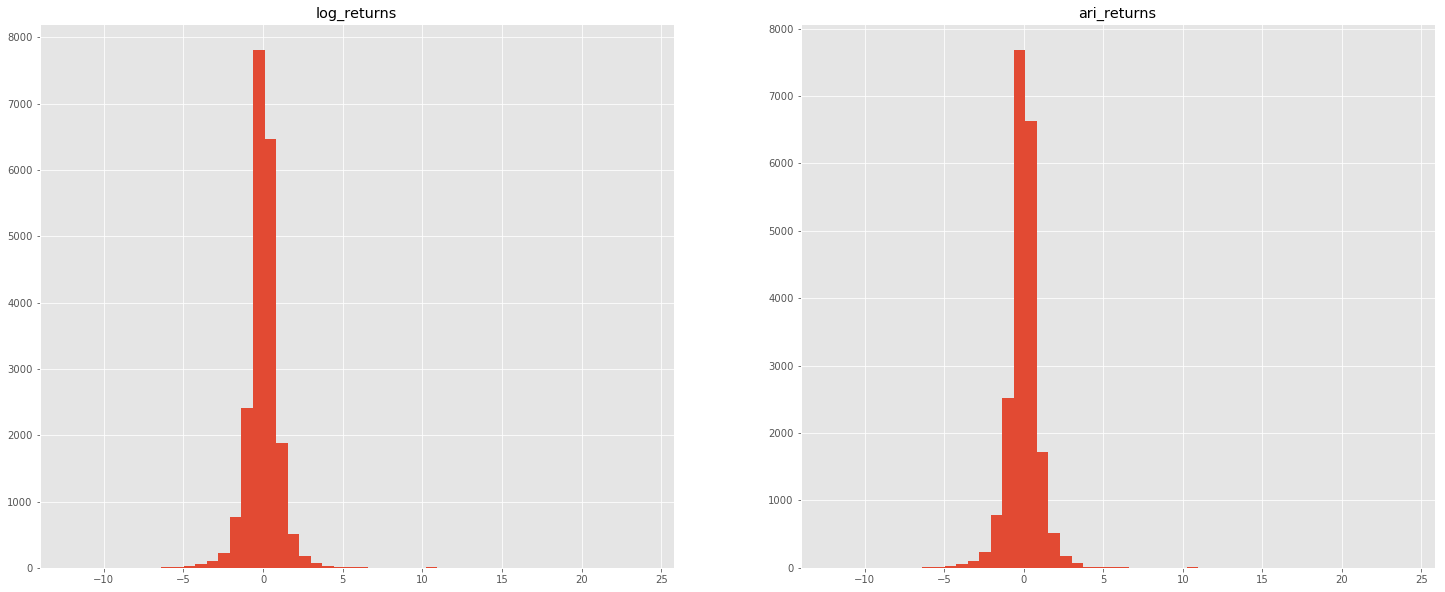

In [843]:
return_types = ['log_returns', 'ari_returns']
fig, axes = plt.subplots(1, len(return_types), figsize=(25,10))
for i, ax in enumerate(axes.reshape(-1)):
    returns = df[return_types[i]].dropna().values.reshape(-1,1)
    returns = StandardScaler().fit_transform(returns)
    ax.hist(returns, bins=50)
    ax.set_title(return_types[i])
plt.show()

# Scale

In [844]:
df.describe()

volume        close         high          low         open  \
count 20597.000000 20597.000000 20597.000000 20597.000000 20597.000000   
mean     21.287226     1.135128     1.135216     1.135040     1.135129   
std      28.597359     0.004987     0.004991     0.004984     0.004987   
min       1.000000     1.123410     1.123580     1.123410     1.123440   
25%       6.000000     1.130250     1.130340     1.130170     1.130260   
50%      14.000000     1.136740     1.136820     1.136660     1.136750   
75%      27.000000     1.139160     1.139260     1.139080     1.139160   
max     884.000000     1.146180     1.146500     1.146080     1.146210   

       log_returns  ari_returns  log_returns_shifted  target_label_direction  \
count 20596.000000 20596.000000         20596.000000            20596.000000   
mean     -0.000000    -0.000000            -0.000000                0.525345   
std       0.000152     0.000152             0.000152                0.499369   
min      -0.001856    -0.001854            -0.001856                0.000000   
25%      -0.000062    -0.000062            -0.000062                0.000000   
50%       0.000000     0.000000             0.000000                1.000000   
75%       0.000062     0.000062             0.000062                1.000000   
max       0.003641     0.003648             0.003641                1.000000   

       target_label_direction_shifted  
count                    20596.000000  
mean                         0.525345  
std                          0.499369  
min                          0.000000  
25%                          0.000000  
50%                          1.000000  
75%                          1.000000  
max                          1.000000

In [845]:
df.drop('complete', axis=1, inplace=True)
scale_columns = ['volume', 'high', 'low', 'close', 'open']
mm = MinMaxScaler()
scale_values = mm.fit_transform(df[scale_columns])
df[scale_columns] = scale_values
print(df.describe())
print(df.shape)
print(df.columns)

            volume        close         high          low         open  \
count 20597.000000 20597.000000 20597.000000 20597.000000 20597.000000   
mean      0.022975     0.514614     0.507698     0.513005     0.513372   
std       0.032387     0.218998     0.217765     0.219849     0.219031   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.005663     0.300395     0.294939     0.298191     0.299517   
50%       0.014723     0.585419     0.577661     0.584473     0.584541   
75%       0.029445     0.691700     0.684119     0.691222     0.690382   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       log_returns  ari_returns  log_returns_shifted  target_label_direction  \
count 20596.000000 20596.000000         20596.000000            20596.000000   
mean     -0.000000    -0.000000            -0.000000                0.525345   
std       0.000152     0.000152             0.000152                0.499369   
min      -0.0

In [846]:
df.head()

volume    close     high      low     open  log_returns  \
time                                                                            
2016-04-01 00:00:00 0.031710 0.637242 0.627400 0.629466 0.633289          nan   
2016-04-01 00:01:00 0.016988 0.642073 0.630454 0.634760 0.634168     0.000097   
2016-04-01 00:02:00 0.011325 0.648661 0.638307 0.645346 0.642073     0.000132   
2016-04-01 00:03:00 0.015855 0.648661 0.639180 0.649316 0.646465     0.000000   
2016-04-01 00:04:00 0.007928 0.648661 0.637871 0.649757 0.647343     0.000000   

                     ari_returns  log_returns_shifted  target_label_direction  \
time                                                                            
2016-04-01 00:00:00          nan             0.000097                     nan   
2016-04-01 00:01:00     0.000097             0.000132                1.000000   
2016-04-01 00:02:00     0.000132             0.000000                1.000000   
2016-04-01 00:03:00     0.000000             0.000000                1.000000   
2016-04-01 00:04:00     0.000000             0.000123                1.000000   

                     target_label_direction_shifted  
time                                                 
2016-04-01 00:00:00                        1.000000  
2016-04-01 00:01:00                        1.000000  
2016-04-01 00:02:00                        1.000000  
2016-04-01 00:03:00                        1.000000  
2016-04-01 00:04:00                        1.000000

# Add Features pandas

In [847]:
# df['20d_ma'] = df['close'].rolling(window=20).mean()
# df['50d_ma'] = df['close'].rolling(window=50).mean()
# df['Bol_upper'] = df['close'].rolling(window=20).mean() + 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_lower'] = df['close'].rolling(window=20).mean() - 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_BW'] = ((df['Bol_upper'] - df['Bol_lower'])/df['20d_ma'])*100
# df['Bol_BW_200MA'] = df['Bol_BW'].rolling(window=50).mean()
# df['20d_exma'] = df['close'].ewm(span=20).mean()
# df['50d_exma'] = df['close'].ewm(span=50).mean()

In [848]:
# df.plot(y=['close','20d_ma','50d_ma','Bol_upper','Bol_lower'], figsize=(25,10))

In [849]:
# df.plot(y=['close', '20d_exma','50d_exma'], figsize=(25,10))

In [850]:
# df.plot(y=['Bol_BW','Bol_BW_200MA'], figsize=(25,10))

# Add Features TA-Lib

In [851]:
print(talib.get_function_groups().keys())
print(talib.get_functions())
#talib.abstract.__all__

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])
['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', '

In [852]:
mom_ind = talib.get_function_groups()['Momentum Indicators']
over_stud = talib.get_function_groups()['Overlap Studies']
volu_ind = talib.get_function_groups()['Volume Indicators']
cyc_ind = talib.get_function_groups()['Cycle Indicators']
vola_ind = talib.get_function_groups()['Volatility Indicators']
talib_abstract_fun_list = mom_ind + over_stud + volu_ind + cyc_ind + vola_ind
# talib_abstract_fun_list = talib.abstract.__all__[1:]
# talib_abstract_fun_list = ['RSI', 'STOCH', 'WILLR', 'ATR', 'MACD']
print(talib_abstract_fun_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE']


In [853]:
talib_abstract_fun_list = [i for i in talib_abstract_fun_list if i not in ['MAVP','ASIN', 'ACOS']]
print(len(talib_abstract_fun_list))

57


In [854]:
print(talib_abstract_fun_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE']


In [855]:
ohlcv = {
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'volume': df['volume'].astype(float)
}

In [856]:
for fun in talib_abstract_fun_list:
    res = getattr(talib.abstract, fun)(ohlcv)
    if len(res) > 10:
        df[fun] = res
    else:
        for i, val in enumerate(res):
            df[fun+'_'+str(i+1)] = val

In [857]:
for per in [3,6,12,18,25, 30]:
    col_name = 'MAVP_'+str(per)
    df[col_name] = talib.MAVP(df['close'].values, periods=np.array([float(per)]*df.shape[0]))

In [858]:
df.head(100)

volume    close     high      low     open  log_returns  \
time                                                                            
2016-04-01 00:00:00 0.031710 0.637242 0.627400 0.629466 0.633289          nan   
2016-04-01 00:01:00 0.016988 0.642073 0.630454 0.634760 0.634168     0.000097   
2016-04-01 00:02:00 0.011325 0.648661 0.638307 0.645346 0.642073     0.000132   
2016-04-01 00:03:00 0.015855 0.648661 0.639180 0.649316 0.646465     0.000000   
2016-04-01 00:04:00 0.007928 0.648661 0.637871 0.649757 0.647343     0.000000   
2016-04-01 00:05:00 0.003398 0.654809 0.643106 0.653286 0.649100     0.000123   
2016-04-01 00:06:00 0.014723 0.653931 0.642234 0.653286 0.651735    -0.000018   
2016-04-01 00:07:00 0.010193 0.653052 0.643979 0.655492 0.654370    -0.000018   
2016-04-01 00:08:00 0.046433 0.669302 0.660558 0.657697 0.653491     0.000325   
2016-04-01 00:09:00 0.012458 0.670619 0.660558 0.670931 0.666667     0.000026   
2016-04-01 00:10:00 0.014723 0.664471 0.657941 0.665637 0.668423    -0.000123   
2016-04-01 00:11:00 0.005663 0.663592 0.654014 0.664755 0.664471    -0.000018   
2016-04-01 00:12:00 0.007928 0.665788 0.654450 0.664755 0.660957     0.000044   
2016-04-01 00:13:00 0.033975 0.670619 0.666667 0.667402 0.663153     0.000097   
2016-04-01 00:14:00 0.013590 0.665788 0.660558 0.668725 0.671058    -0.000097   
2016-04-01 00:15:00 0.019253 0.667984 0.657941 0.668725 0.665788     0.000044   
2016-04-01 00:16:00 0.026048 0.659201 0.655323 0.660344 0.665788    -0.000176   
2016-04-01 00:17:00 0.018120 0.653052 0.649215 0.655051 0.658762    -0.000123   
2016-04-01 00:18:00 0.009060 0.652613 0.646597 0.655492 0.652613    -0.000009   
2016-04-01 00:19:00 0.015855 0.662714 0.650960 0.656815 0.652613     0.000202   
2016-04-01 00:20:00 0.024915 0.661836 0.655323 0.662991 0.663153    -0.000018   
2016-04-01 00:21:00 0.013590 0.654809 0.650087 0.656374 0.660518    -0.000141   
2016-04-01 00:22:00 0.005663 0.654809 0.645288 0.657697 0.654809     0.000000   
2016-04-01 00:23:00 0.011325 0.655687 0.645724 0.655933 0.654370     0.000018   
2016-04-01 00:24:00 0.015855 0.659201 0.648342 0.655933 0.654370     0.000070   
2016-04-01 00:25:00 0.013590 0.657005 0.651832 0.659903 0.659640    -0.000044   
2016-04-01 00:26:00 0.003398 0.655248 0.646597 0.658139 0.657005    -0.000035   
2016-04-01 00:27:00 0.014723 0.655687 0.646597 0.655492 0.655248     0.000009   
2016-04-01 00:28:00 0.005663 0.658322 0.646597 0.659462 0.655248     0.000053   
2016-04-01 00:29:00 0.011325 0.657883 0.648342 0.659021 0.658762    -0.000009   
...                      ...      ...      ...      ...      ...          ...   
2016-04-01 01:10:00 0.016988 0.631972 0.624782 0.633877 0.629776     0.000035   
2016-04-01 01:11:00 0.004530 0.631533 0.623037 0.634318 0.631972    -0.000009   
2016-04-01 01:12:00 0.006795 0.626702 0.619546 0.629466 0.629337    -0.000097   
2016-04-01 01:13:00 0.005663 0.627580 0.617801 0.629466 0.626702     0.000018   
2016-04-01 01:14:00 0.016988 0.624506 0.615183 0.625937 0.625384    -0.000062   
2016-04-01 01:15:00 0.013590 0.628458 0.616928 0.627702 0.624506     0.000079   
2016-04-01 01:16:00 0.006795 0.628458 0.616928 0.628584 0.626263     0.000000   
2016-04-01 01:17:00 0.006795 0.625384 0.616492 0.627261 0.626702    -0.000062   
2016-04-01 01:18:00 0.015855 0.624067 0.612565 0.620644 0.622749    -0.000026   
2016-04-01 01:19:00 0.018120 0.620553 0.612565 0.620644 0.620993    -0.000070   
2016-04-01 01:20:00 0.019253 0.622310 0.611693 0.615351 0.620114     0.000035   
2016-04-01 01:21:00 0.005663 0.617479 0.609948 0.620203 0.620114    -0.000097   
2016-04-01 01:22:00 0.012458 0.613527 0.609075 0.615351 0.617479    -0.000079   
2016-04-01 01:23:00 0.005663 0.610892 0.602094 0.613586 0.610892    -0.000053   
2016-04-01 01:24:00 0.012458 0.614405 0.602967 0.613145 0.610452     0.000070   
2016-04-01 01:25:00 0.013590 0.619236 0.607766 0.615792 0.614844     0.000097   
2016-04-01 01:26:00 0.019253 0.610892 0.606457 0.6135

In [822]:
ss = MinMaxScaler()
x = np.array([1,1,1,1,0,0,0,0,1,1,1,0,0,0])
x

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [823]:
x_ss = ss.fit_transform(x.reshape(-1,1))
x_ss

/home/applesauce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [720]:
list(df.columns)

['volume',
 'close',
 'high',
 'low',
 'open',
 'log_returns',
 'ari_returns',
 'log_returns_shifted',
 'target_label_direction',
 'target_label_direction_shifted',
 'ADX',
 'ADXR',
 'APO',
 'AROON_1',
 'AROON_2',
 'AROONOSC',
 'BOP',
 'CCI',
 'CMO',
 'DX',
 'MACD_1',
 'MACD_2',
 'MACD_3',
 'MACDEXT_1',
 'MACDEXT_2',
 'MACDEXT_3',
 'MACDFIX_1',
 'MACDFIX_2',
 'MACDFIX_3',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'MOM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCP',
 'ROCR',
 'ROCR100',
 'RSI',
 'STOCH_1',
 'STOCH_2',
 'STOCHF_1',
 'STOCHF_2',
 'STOCHRSI_1',
 'STOCHRSI_2',
 'TRIX',
 'ULTOSC',
 'WILLR',
 'BBANDS_1',
 'BBANDS_2',
 'BBANDS_3',
 'DEMA',
 'EMA',
 'HT_TRENDLINE',
 'KAMA',
 'MA',
 'MAMA_1',
 'MAMA_2',
 'MIDPOINT',
 'MIDPRICE',
 'SAR',
 'SAREXT',
 'SMA',
 'T3',
 'TEMA',
 'TRIMA',
 'WMA',
 'AD',
 'ADOSC',
 'OBV',
 'HT_DCPERIOD',
 'HT_DCPHASE',
 'HT_PHASOR_1',
 'HT_PHASOR_2',
 'HT_SINE_1',
 'HT_SINE_2',
 'HT_TRENDMODE',
 'ATR',
 'NATR',
 'TRANGE',
 'MAVP_3',
 'MAVP_6',
 'MAVP_12',
 '

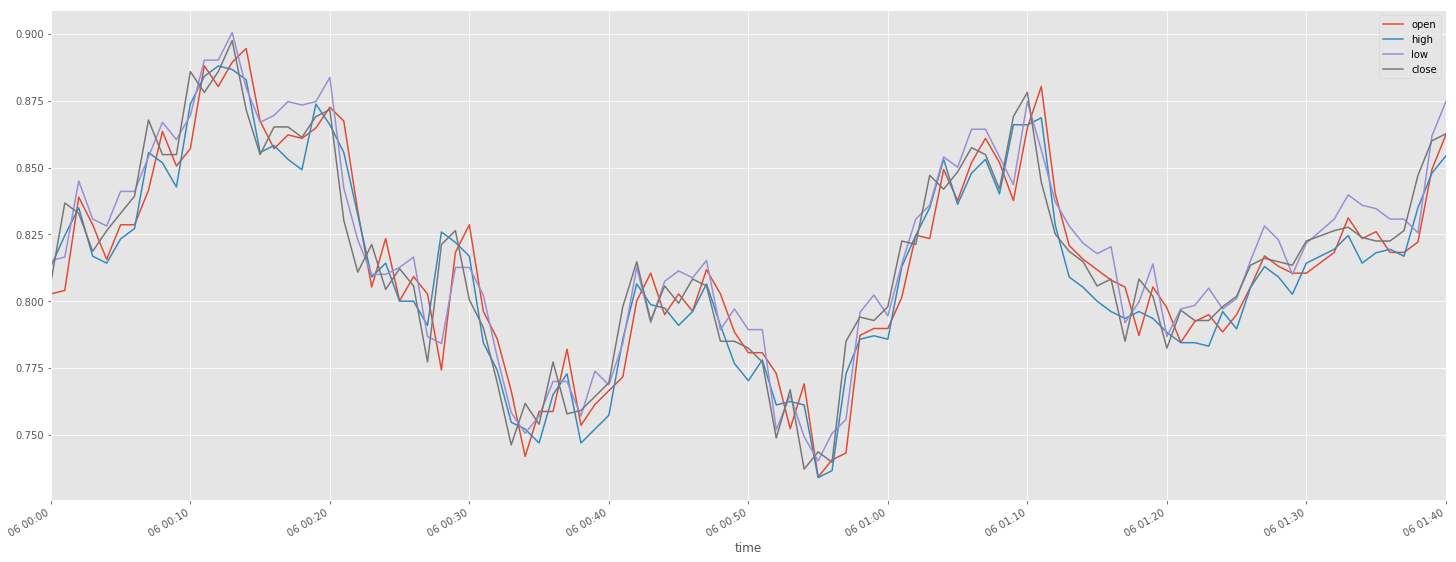

In [721]:
df.iloc[:100].plot(y=['open', 'high', 'low', 'close'], figsize=(25,10))

In [722]:
# for indi in df.columns:
#     df.plot(y=[indi], figsize=(25,10))

In [723]:
# df.iloc[:300].plot(y=['MAC'], figsize=(25,10))

In [724]:
# for col in df.columns:
#     if df[col].isnull().all():
#         print(col)
#         df.drop(col, axis=1, inplace=True)
# df.drop(['ASIN', 'ACOS'],axis=1, inplace=True)

In [725]:
df.shape[0] - df.dropna().shape[0]

89

In [726]:
drop_columns = ['volume', 'close', 'high', 'low', 'open', 'complete', 'log_returns', 'ari_returns', 'log_returns_shifted', 'target_label_direction', 'target_label_direction_shifted']
predict_columns = [i for i in df.columns if i not in drop_columns]
print(predict_columns)
print(len(predict_columns))

['ADX', 'ADXR', 'APO', 'AROON_1', 'AROON_2', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD_1', 'MACD_2', 'MACD_3', 'MACDEXT_1', 'MACDEXT_2', 'MACDEXT_3', 'MACDFIX_1', 'MACDFIX_2', 'MACDFIX_3', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH_1', 'STOCH_2', 'STOCHF_1', 'STOCHF_2', 'STOCHRSI_1', 'STOCHRSI_2', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS_1', 'BBANDS_2', 'BBANDS_3', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_1', 'MAMA_2', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_1', 'HT_PHASOR_2', 'HT_SINE_1', 'HT_SINE_2', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE', 'MAVP_3', 'MAVP_6', 'MAVP_12', 'MAVP_18', 'MAVP_25', 'MAVP_30']
78


In [859]:
df.describe()

volume        close         high          low         open  \
count 20597.000000 20597.000000 20597.000000 20597.000000 20597.000000   
mean      0.022975     0.514614     0.507698     0.513005     0.513372   
std       0.032387     0.218998     0.217765     0.219849     0.219031   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.005663     0.300395     0.294939     0.298191     0.299517   
50%       0.014723     0.585419     0.577661     0.584473     0.584541   
75%       0.029445     0.691700     0.684119     0.691222     0.690382   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       log_returns  ari_returns  log_returns_shifted  target_label_direction  \
count 20596.000000 20596.000000         20596.000000            20596.000000   
mean     -0.000000    -0.000000            -0.000000                0.525345   
std       0.000152     0.000152             0.000152                0.499369   
min      -0.001856    -0.001854            -0.001856                0.000000   
25%      -0.000062    -0.000062            -0.000062                0.000000   
50%       0.000000     0.000000             0.000000                1.000000   
75%       0.000062     0.000062             0.000062                1.000000   
max       0.003641     0.003648             0.003641                1.000000   

       target_label_direction_shifted          ADX         ADXR          APO  \
count                    20596.000000 20570.000000 20557.000000 20572.000000   
mean                         0.525345    23.466014    23.465328    -0.000139   
std                          0.499369     9.409574     8.380309     0.010932   
min                          0.000000     6.563497     7.737710    -0.083072   
25%                          0.000000    16.582664    17.380645    -0.005062   
50%                          1.000000    21.572425    22.020892    -0.000117   
75%                          1.000000    28.406168    27.843689     0.004946   
max                          1.000000    64.029092    61.784563     0.074403   

           AROON_1      AROON_2     AROONOSC          BOP          CCI  \
count 20583.000000 20583.000000 20583.000000 20597.000000 20584.000000   
mean     49.697739    49.249381    -0.448359     0.575278    -1.094172   
std      36.332781    36.505380    63.322330    84.493645   108.197446   
min       0.000000     0.000000  -100.000000 -2738.320954  -402.143600   
25%      14.285714    14.285714   -57.142857     0.000000   -86.568187   
50%      50.000000    50.000000     0.000000     0.000000    -2.225493   
75%      85.714286    85.714286    57.142857     0.000000    84.236642   
max     100.000000   100.000000   100.000000 11409.670704   466.666667   

               CMO           DX       MACD_1       MACD_2       MACD_3  \
count 20583.000000 20583.000000 20564.000000 20564.000000 20564.000000   
mean     -0.416298    23.459245    -0.000139    -0.000138    -0.000000   
std      21.945346    16.944407     0.007778     0.007314     0.002366   
min     -75.860351     0.000730    -0.070854    -0.063710    -0.019433   
25%     -15.311182     9.576945    -0.003612    -0.003391    -0.001114   
50%      -0.431957    20.463875    -0.000164    -0.000153    -0.000001   
75%      14.728184    34.140312     0.003304     0.003069     0.001148   
max      71.007395    85.155486     0.039864     0.036574     0.020306   

         MACDEXT_1    MACDEXT_2    MACDEXT_3    MACDFIX_1    MACDFIX_2  \
count 20564.000000 20564.000000 20564.000000 20564.000000 20564.000000   
mean     -0.000139    -0.000139     0.000000    -0.000132    -0.000132   
std       0.010934     0.010391     0.005073     0.007407     0.006969   
min      -0.083072    -0.076955    -0.029074    -0.067424    -0.060709   
25%      -0.005065    -0.004795    -0.002448    -0.003446    -0.003232   
50%      -0.000113    -0.000098    -0.000021    -0.000155    -0.000144   
75%       0.004949     0.004675     0.002409     0.

In [860]:
df.shape

(20597, 88)

In [861]:
df.dropna(inplace=True)
df.shape

(20508, 88)

In [862]:
y = df['target_label_direction_shifted']
x = df[predict_columns]
print(x.shape, y.shape)
up = sum(y == 1) / len(y) * 100
print('up: {:.2f}%\ndown: {:.2f}%'.format(up, 100-up))

(20508, 78) (20508,)
up: 52.54%
down: 47.46%


In [863]:
mm = MinMaxScaler()
x_mm = mm.fit_transform(x)
x_mm = pd.DataFrame(x, columns=predict_columns)

In [864]:
x_mm.describe()

ADX         ADXR          APO      AROON_1      AROON_2  \
count 20508.000000 20508.000000 20508.000000 20508.000000 20508.000000   
mean     23.449118    23.455183    -0.000127    49.665636    49.291566   
std       9.410256     8.383683     0.010943    36.332145    36.512861   
min       6.563497     7.737710    -0.083072     0.000000     0.000000   
25%      16.570594    17.366725    -0.005059    14.285714    14.285714   
50%      21.558878    22.005351    -0.000097    50.000000    50.000000   
75%      28.378998    27.832271     0.004967    85.714286    85.714286   
max      64.029092    61.784563     0.074403   100.000000   100.000000   

          AROONOSC          BOP          CCI          CMO           DX  \
count 20508.000000 20508.000000 20508.000000 20508.000000 20508.000000   
mean     -0.374070     0.576640    -0.960205    -0.406500    23.432714   
std      63.343998    84.676601   108.234769    21.942753    16.938889   
min    -100.000000 -2738.320954  -402.143600   -75.860351     0.000730   
25%     -57.142857     0.000000   -86.475559   -15.287637     9.560603   
50%       0.000000     0.000000    -1.922274    -0.430142    20.423546   
75%      57.142857     0.000000    84.431146    14.731475    34.120693   
max     100.000000 11409.670704   466.666667    71.007395    85.155486   

            MACD_1       MACD_2       MACD_3    MACDEXT_1    MACDEXT_2  \
count 20508.000000 20508.000000 20508.000000 20508.000000 20508.000000   
mean     -0.000130    -0.000131     0.000001    -0.000127    -0.000128   
std       0.007784     0.007321     0.002368     0.010943     0.010400   
min      -0.070854    -0.063710    -0.019433    -0.083072    -0.076955   
25%      -0.003601    -0.003385    -0.001115    -0.005059    -0.004787   
50%      -0.000155    -0.000148     0.000001    -0.000097    -0.000092   
75%       0.003312     0.003082     0.001150     0.004967     0.004689   
max       0.039864     0.036574     0.020306     0.074403     0.059909   

         MACDEXT_3    MACDFIX_1    MACDFIX_2    MACDFIX_3          MFI  \
count 20508.000000 20508.000000 20508.000000 20508.000000 20508.000000   
mean      0.000001    -0.000124    -0.000125     0.000001     0.529716   
std       0.005076     0.007413     0.006975     0.002248     5.448970   
min      -0.029074    -0.067424    -0.060709    -0.018403     0.000000   
25%      -0.002450    -0.003439    -0.003226    -0.001058     0.000000   
50%      -0.000025    -0.000146    -0.000139     0.000001     0.000000   
75%       0.002413     0.003153     0.002936     0.001089     0.000000   
max       0.035916     0.037960     0.034841     0.019128    94.375711   

          MINUS_DI     MINUS_DM          MOM      PLUS_DI      PLUS_DM  \
count 20508.000000 20508.000000 20508.000000 20508.000000 20508.000000   
mean     23.755193     0.029855    -0.000179    23.587506     0.028536   
std      12.241716     0.020496     0.022243    14.246501     0.019007   
min       2.834455     0.003724    -0.203338     2.137636     0.003358   
25%      13.856931     0.017018    -0.010540    12.746185     0.016118   
50%      21.482948     0.024771     0.000000    19.909120     0.023571   
75%      31.686155     0.036238     0.010540    31.397576     0.035454   
max      77.486359     0.265692     0.208169    88.574710     0.299955   

               PPO          ROC         ROCP         ROCR      ROCR100  \
count 20508.000000 20508.000000 20508.000000 20508.000000 20508.000000   
mean     -0.023550     0.294558     0.002946     1.002897   100.289682   
std       3.716052    10.819245     0.108192     0.108419    10.841889   
min     -58.549588  -100.000000    -1.000000     0.000000     0.000000   
25%      -1.052171    -2.102478    -0.021025     0.978968    97.896762   
50%      -0.019971     0.000000     0.000000     1.000000   100.000000   
75%       1.081756     2.268487     0.022685     1.022685   102.268487   
max      44.307400   758.333333     7.583333     8.583333   858.333333   

             

In [865]:
pca = PCA(n_components=len(predict_columns))

In [867]:
pca.fit(x_mm)

PCA(copy=True, iterated_power='auto', n_components=78, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[  70.62   93.43   97.33   99.72   99.96   99.98   99.99  100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.    100.    100.    100.
  100.    100.    100.    100.    100.    100.  ]


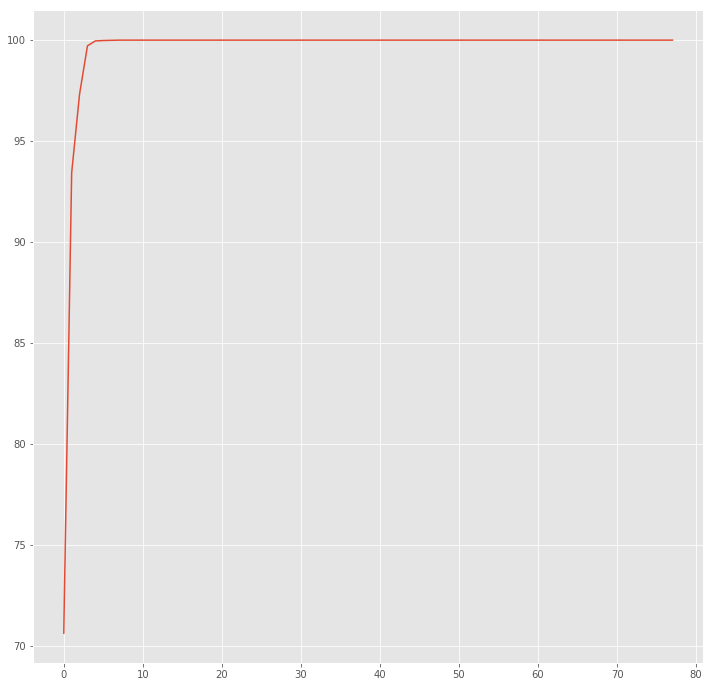

In [868]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)

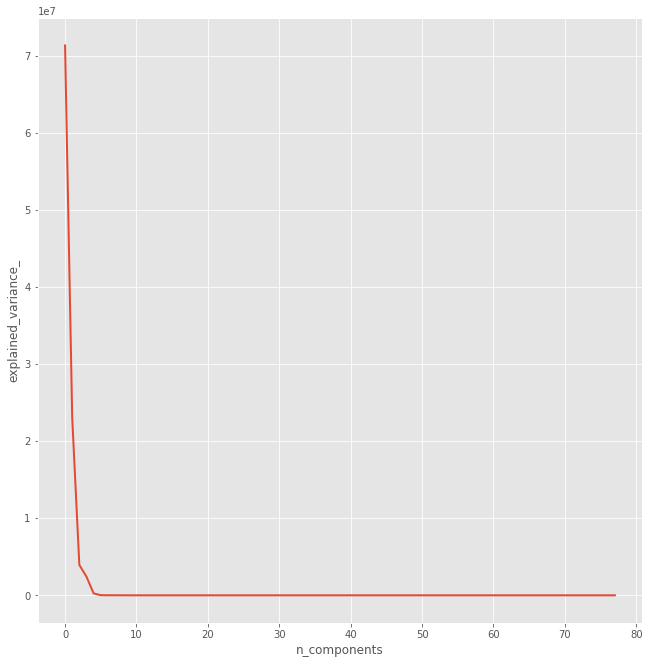

In [869]:
# Plot the PCA spectrum
pca = PCA()
pca.fit(x_mm)
plt.figure(1)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [870]:
pca = PCA(n_components=5)
x_mm_pca =pca.fit_transform(x_mm)
type(x_mm_pca)

numpy.ndarray

In [872]:
print(x_mm_pca.shape)

(20508, 5)


In [873]:
split_index = int(df.shape[0]*.5)
x_train, x_test = x_mm_pca[:split_index], x_mm_pca[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
y_test = pd.Series(y_test.values)

(10254, 5) (10254, 5)
(10254,) (10254,)


In [874]:
# x_train, x_test, y_train, y_test = train_test_split(x, y)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Model

In [875]:
mom_cols = []
for mom_time in [1, 15, 30, 60, 120]:
    col = 'average_log_return_{}_sign'.format(mom_time)
    df[col] = df['log_returns'].rolling(mom_time).mean().apply(up_down) #the sign of the average returns of the last x candles
    mom_cols.append(col)
print(mom_cols)

['average_log_return_1_sign', 'average_log_return_15_sign', 'average_log_return_30_sign', 'average_log_return_60_sign', 'average_log_return_120_sign']


In [876]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [877]:
for mod in models:
    #print(mod.steps[1][1].__class__.__name__)
    print(mod.__class__.__name__)
    print(np.mean(cross_val_score(mod, x_mm_pca, y, cv=3, n_jobs=-1)))

LogisticRegression
0.524722131366
DecisionTreeClassifier
0.500634505289
RandomForestClassifier
0.505218724481
AdaBoostClassifier
0.51809135031
GradientBoostingClassifier
0.518725013906


In [878]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [879]:
for mod in models:
    mod.fit(x_train, y_train)

In [880]:
df.head()

volume    close     high      low     open  log_returns  \
time                                                                            
2016-04-01 01:28:00 0.029445 0.627580 0.617801 0.621085 0.617040     0.000158   
2016-04-01 01:29:00 0.020385 0.633289 0.625654 0.631231 0.627141     0.000114   
2016-04-01 01:30:00 0.024915 0.624067 0.620419 0.624173 0.630654    -0.000185   
2016-04-01 01:31:00 0.026048 0.634607 0.624782 0.625496 0.621432     0.000211   
2016-04-01 01:32:00 0.013590 0.629337 0.622600 0.632113 0.632850    -0.000105   

                     ari_returns  log_returns_shifted  target_label_direction  \
time                                                                            
2016-04-01 01:28:00     0.000158             0.000114                1.000000   
2016-04-01 01:29:00     0.000114            -0.000185                1.000000   
2016-04-01 01:30:00    -0.000185             0.000211                0.000000   
2016-04-01 01:31:00     0.000211            -0.000105                1.000000   
2016-04-01 01:32:00    -0.000105            -0.000009                0.000000   

                     target_label_direction_shifted       ADX      ADXR  \
time                                                                      
2016-04-01 01:28:00                        1.000000 36.292178 34.759302   
2016-04-01 01:29:00                        0.000000 34.541944 33.719577   
2016-04-01 01:30:00                        1.000000 32.282816 32.521983   
2016-04-01 01:31:00                        0.000000 30.360587 31.872147   
2016-04-01 01:32:00                        0.000000 28.575659 31.268728   

                          APO   AROON_1    AROON_2  AROONOSC      BOP  \
time                                                                    
2016-04-01 01:28:00 -0.003933 71.428571 100.000000 28.571429 0.000000   
2016-04-01 01:29:00 -0.003494 64.285714 100.000000 35.714286 0.000000   
2016-04-01 01:30:00 -0.003612 57.142857  92.857143 35.714286 0.000000   
2016-04-01 01:31:00 -0.003015 50.000000  85.714286 35.714286 0.000000   
2016-04-01 01:32:00 -0.002801 42.857143  78.571429 35.714286 0.000000   

                           CCI       CMO        DX    MACD_1    MACD_2  \
time                                                                     
2016-04-01 01:28:00  82.042566  3.032385  4.574885 -0.005332 -0.006574   
2016-04-01 01:29:00 176.431316 11.643529 11.788901 -0.003888 -0.006037   
2016-04-01 01:30:00  82.831483 -3.296069  2.914154 -0.003448 -0.005519   
2016-04-01 01:31:00 140.830155 11.310673  5.371600 -0.002223 -0.004860   
2016-04-01 01:32:00 112.883470  3.434931  5.371600 -0.001659 -0.004220   

                      MACD_3  MACDEXT_1  MACDEXT_2  MACDEXT_3  MACDFIX_1  \
time                                                                       
2016-04-01 01:28:00 0.001242  -0.003933  -0.004695   0.000762  -0.005105   
2016-04-01 01:29:00 0.002149  -0.003494  -0.004427   0.000934  -0.003743   
2016-04-01 01:30:00 0.002071  -0.003612  -0.004246   0.000634  -0.003321   
2016-04-01 01:31:00 0.002637  -0.003015  -0.004036   0.001021  -0.002162   
2016-04-01 01:32:00 0.002561  -0.002801  -0.003760   0.000959  -0.001621   

                     MACDFIX_2  MACDFIX_3      MFI  MINUS_DI  MINUS_DM  \
time                                                                     
2016-04-01 01:28:00  -0.006275   0.001170 0.000000 19.388285  0.023839   
2016-04-01 01:29:00  -0.005769   0.002026 0.000000 18.787563  0.022136   
2016-04-01 01:30:00  -0.005279   0.001958 0.000000 22.582022  0.027612   
2016-04-01 01:31:00  -0.004656   0.002494 0.000000 22.301249  0.025640   
2016-04-01 01:32:00  -0.004049   0.002428 0.000000 20.046715  0.023809   

                         MOM   PLUS_DI  PLUS_DM       PPO      ROC     ROCP  \
time                                                                          
2016-04-01 01:28:00 0.003513 17.691908 0.021753 -0.631515 0.562984 0.005630   
2016-04-01 01:29:00 0.012736 23.809260 0

In [881]:
y_test

0       0.000000
1       0.000000
2       1.000000
3       1.000000
4       0.000000
5       0.000000
6       1.000000
7       1.000000
8       1.000000
9       0.000000
10      1.000000
11      0.000000
12      1.000000
13      0.000000
14      0.000000
15      1.000000
16      0.000000
17      0.000000
18      1.000000
19      1.000000
20      1.000000
21      1.000000
22      1.000000
23      1.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      1.000000
29      1.000000
          ...   
10224   0.000000
10225   1.000000
10226   0.000000
10227   0.000000
10228   1.000000
10229   1.000000
10230   1.000000
10231   0.000000
10232   1.000000
10233   0.000000
10234   0.000000
10235   1.000000
10236   1.000000
10237   0.000000
10238   0.000000
10239   1.000000
10240   0.000000
10241   0.000000
10242   1.000000
10243   0.000000
10244   1.000000
10245   0.000000
10246   0.000000
10247   0.000000
10248   0.000000
10249   1.000000
10250   0.000000
10251   1.0000

In [882]:
predict_df_cols = ['log_returns'] + mom_cols
prediction_df = df[predict_df_cols][split_index:]
print(type(prediction_df))
prediction_df.head(50)

<class 'pandas.core.frame.DataFrame'>


log_returns  average_log_return_1_sign  \
time                                                          
2016-04-12 12:07:00    -0.000167                          0   
2016-04-12 12:08:00    -0.000070                          0   
2016-04-12 12:09:00    -0.000561                          0   
2016-04-12 12:10:00     0.000053                          1   
2016-04-12 12:11:00     0.000070                          1   
2016-04-12 12:12:00    -0.000140                          0   
2016-04-12 12:13:00    -0.000018                          0   
2016-04-12 12:14:00     0.000009                          1   
2016-04-12 12:15:00     0.000061                          1   
2016-04-12 12:16:00     0.000140                          1   
2016-04-12 12:17:00    -0.000140                          0   
2016-04-12 12:18:00     0.000000                          1   
2016-04-12 12:19:00    -0.000167                          0   
2016-04-12 12:20:00     0.000070                          1   
2016-04-12 12:21:00    -0.000088                          0   
2016-04-12 12:22:00    -0.000009                          0   
2016-04-12 12:23:00     0.000053                          1   
2016-04-12 12:24:00    -0.000123                          0   
2016-04-12 12:25:00    -0.000228                          0   
2016-04-12 12:26:00     0.000053                          1   
2016-04-12 12:27:00     0.000211                          1   
2016-04-12 12:28:00     0.000000                          1   
2016-04-12 12:29:00     0.000105                          1   
2016-04-12 12:30:00     0.000263                          1   
2016-04-12 12:31:00     0.000360                          1   
2016-04-12 12:32:00    -0.000053                          0   
2016-04-12 12:33:00    -0.000009                          0   
2016-04-12 12:34:00    -0.000009                          0   
2016-04-12 12:35:00    -0.000149                          0   
2016-04-12 12:36:00     0.000158                          1   
2016-04-12 12:37:00     0.000079                          1   
2016-04-12 12:38:00     0.000079                          1   
2016-04-12 12:39:00    -0.000561                          0   
2016-04-12 12:40:00     0.000263                          1   
2016-04-12 12:41:00     0.000123                          1   
2016-04-12 12:42:00     0.000061                          1   
2016-04-12 12:43:00    -0.000202                          0   
2016-04-12 12:44:00    -0.000105                          0   
2016-04-12 12:45:00    -0.000158                          0   
2016-04-12 12:46:00     0.000035                          1   
2016-04-12 12:47:00     0.000018                          1   
2016-04-12 12:48:00     0.000053                          1   
2016-04-12 12:49:00    -0.000053                          0   
2016-04-12 12:50:00    -0.000369                          0   
2016-04-12 12:51:00    -0.000158                          0   
2016-04-12 12:52:00    -0.000298                          0   
2016-04-12 12:53:00    -0.000562                          0   
2016-04-12 12:54:00     0.000035                          1   
2016-04-12 12:55:00     0.000105                          1   
2016-04-12 12:56:00     0.000070                          1   

                     average_log_return_15_sign  average_log_return_30_sign  \
time                                                                          
2016-04-12 12:07:00                    0.000000                    0.000000   
2016-04-12 12:08:00                    0.000000                    0.000000   
2016-04-12 12:09:00                    0.000000                    0.000000   
2016-04-12 12:10:00                    0.000000                    0.000000   
2016-04-12 12:11:00                    0.000000                    0.000000   
2016-04-12 12:12:00                    0.000000                    0.000000   
2016-04-12 12:13:00                    0.000000                    0.000000   
2016-04-12 12:14:00              

In [883]:
for mod in models:
    #mod_name = mod.steps[1][1].__class__.__name__
    mod_name = mod.__class__.__name__
    print(mod_name)
    print('----------------------------')
    print('accuracy', mod.score(x_test, y_test))
    print('----------------------------')
    y_pred = mod.predict(x_test)
    prediction_df[mod_name] = y_pred
    y_pred = pd.Series(y_pred, name='pred')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

LogisticRegression
----------------------------
accuracy 0.478935049737
----------------------------
recall 0.104655493482
----------------------------
precision 0.512306289881
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000      4349       535
1.000000      4808       562
----------------------------
             precision    recall  f1-score   support

        0.0       0.47      0.89      0.62      4884
        1.0       0.51      0.10      0.17      5370

avg / total       0.49      0.48      0.39     10254

----------------------------
DecisionTreeClassifier
----------------------------
accuracy 0.513068070997
----------------------------
recall 0.630167597765
----------------------------
precision 0.529494601784
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000      1877      3007
1.000000      1986      3384
----------------------------
             precision    recall  f1-score   suppo

LogisticRegression 0.494019578237
DecisionTreeClassifier 0.507241866041
RandomForestClassifier 0.498518725684
AdaBoostClassifier 0.52455393433
GradientBoostingClassifier 0.498705193258


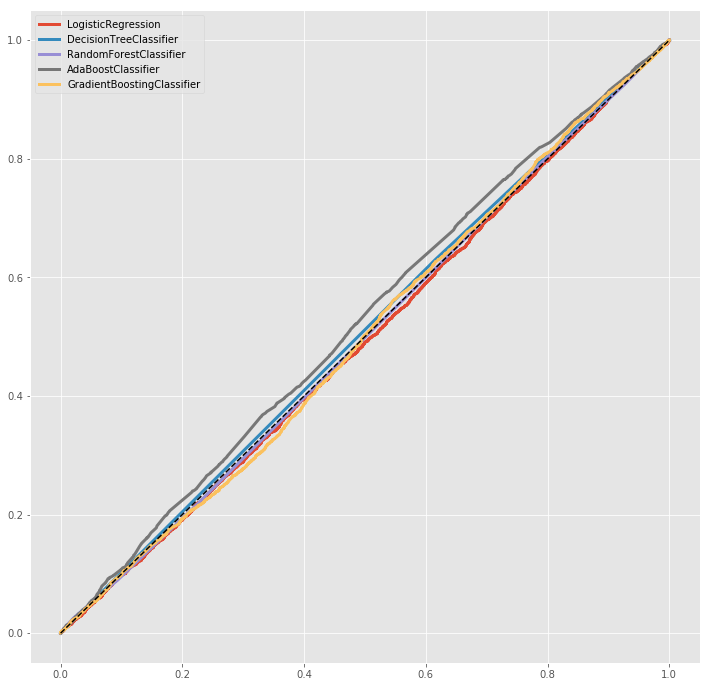

In [884]:
for classer in models:
    probas = classer.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    classer_name = classer.__class__.__name__
    #classer_name = classer.steps[1][1].__class__.__name__
    print(classer_name, roc_auc)
    plt.plot(fpr, tpr, lw=3, label=classer_name)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')

In [885]:
for classer in models[2:]:
    feat_impor = classer.feature_importances_
    x_feat = pd.DataFrame({'cols': x.columns, 'feat_impo': feat_impor})
    classer_name = classer.__class__.__name__
    print(classer_name, '\n', x_feat.sort_values(by='feat_impo', ascending=False))

ValueError: arrays must all be same length

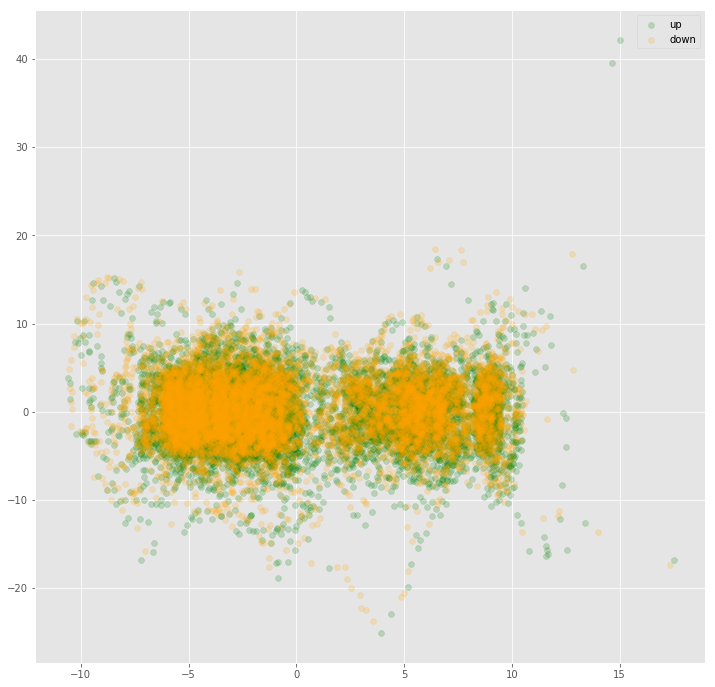

In [886]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
x_new = pca.fit_transform(x)
fig, ax = plt.subplots()
x_new_one = x_new[y==1]
x_new_zero = x_new[y==0]
ax.scatter(x_new_one[:,0], x_new_one[:,1], c='green', label='up', alpha=.2)
ax.scatter(x_new_zero[:,0], x_new_zero[:,1], c='orange', label='down', alpha=.2)
plt.legend(loc='best')

In [887]:
model_list = list(prediction_df.columns[1:])
for mod_col in model_list:
    prediction_df[mod_col] = prediction_df[mod_col].map({1:1, 0:-1}).shift(1)

In [888]:
prediction_df.head()

log_returns  average_log_return_1_sign  \
time                                                          
2016-04-12 12:07:00    -0.000167                        nan   
2016-04-12 12:08:00    -0.000070                  -1.000000   
2016-04-12 12:09:00    -0.000561                  -1.000000   
2016-04-12 12:10:00     0.000053                  -1.000000   
2016-04-12 12:11:00     0.000070                   1.000000   

                     average_log_return_15_sign  average_log_return_30_sign  \
time                                                                          
2016-04-12 12:07:00                         nan                         nan   
2016-04-12 12:08:00                   -1.000000                   -1.000000   
2016-04-12 12:09:00                   -1.000000                   -1.000000   
2016-04-12 12:10:00                   -1.000000                   -1.000000   
2016-04-12 12:11:00                   -1.000000                   -1.000000   

                     average_log_return_60_sign  average_log_return_120_sign  \
time                                                                           
2016-04-12 12:07:00                         nan                          nan   
2016-04-12 12:08:00                   -1.000000                    -1.000000   
2016-04-12 12:09:00                   -1.000000                    -1.000000   
2016-04-12 12:10:00                   -1.000000                    -1.000000   
2016-04-12 12:11:00                   -1.000000                    -1.000000   

                     LogisticRegression  DecisionTreeClassifier  \
time                                                              
2016-04-12 12:07:00                 nan                     nan   
2016-04-12 12:08:00            1.000000                1.000000   
2016-04-12 12:09:00            1.000000                1.000000   
2016-04-12 12:10:00            1.000000                1.000000   
2016-04-12 12:11:00            1.000000               -1.000000   

                     RandomForestClassifier  AdaBoostClassifier  \
time                                                              
2016-04-12 12:07:00                     nan                 nan   
2016-04-12 12:08:00               -1.000000            1.000000   
2016-04-12 12:09:00               -1.000000            1.000000   
2016-04-12 12:10:00               -1.000000            1.000000   
2016-04-12 12:11:00               -1.000000            1.000000   

                     GradientBoostingClassifier  
time                                             
2016-04-12 12:07:00                         nan  
2016-04-12 12:08:00                    1.000000  
2016-04-12 12:09:00                    1.000000  
2016-04-12 12:10:00                    1.000000  
2016-04-12 12:11:00                    1.000000

In [889]:
model_returns = ['log_returns']
for mod_col in model_list:
    model_returns.append(mod_col+'_returns')
    prediction_df[mod_col+'_returns'] = prediction_df[mod_col] * prediction_df['log_returns']

In [890]:
prediction_df.head()

log_returns  average_log_return_1_sign  \
time                                                          
2016-04-12 12:07:00    -0.000167                        nan   
2016-04-12 12:08:00    -0.000070                  -1.000000   
2016-04-12 12:09:00    -0.000561                  -1.000000   
2016-04-12 12:10:00     0.000053                  -1.000000   
2016-04-12 12:11:00     0.000070                   1.000000   

                     average_log_return_15_sign  average_log_return_30_sign  \
time                                                                          
2016-04-12 12:07:00                         nan                         nan   
2016-04-12 12:08:00                   -1.000000                   -1.000000   
2016-04-12 12:09:00                   -1.000000                   -1.000000   
2016-04-12 12:10:00                   -1.000000                   -1.000000   
2016-04-12 12:11:00                   -1.000000                   -1.000000   

                     average_log_return_60_sign  average_log_return_120_sign  \
time                                                                           
2016-04-12 12:07:00                         nan                          nan   
2016-04-12 12:08:00                   -1.000000                    -1.000000   
2016-04-12 12:09:00                   -1.000000                    -1.000000   
2016-04-12 12:10:00                   -1.000000                    -1.000000   
2016-04-12 12:11:00                   -1.000000                    -1.000000   

                     LogisticRegression  DecisionTreeClassifier  \
time                                                              
2016-04-12 12:07:00                 nan                     nan   
2016-04-12 12:08:00            1.000000                1.000000   
2016-04-12 12:09:00            1.000000                1.000000   
2016-04-12 12:10:00            1.000000                1.000000   
2016-04-12 12:11:00            1.000000               -1.000000   

                     RandomForestClassifier  AdaBoostClassifier  \
time                                                              
2016-04-12 12:07:00                     nan                 nan   
2016-04-12 12:08:00               -1.000000            1.000000   
2016-04-12 12:09:00               -1.000000            1.000000   
2016-04-12 12:10:00               -1.000000            1.000000   
2016-04-12 12:11:00               -1.000000            1.000000   

                     GradientBoostingClassifier  \
time                                              
2016-04-12 12:07:00                         nan   
2016-04-12 12:08:00                    1.000000   
2016-04-12 12:09:00                    1.000000   
2016-04-12 12:10:00                    1.000000   
2016-04-12 12:11:00                    1.000000   

                     average_log_return_1_sign_returns  \
time                                                     
2016-04-12 12:07:00                                nan   
2016-04-12 12:08:00                           0.000070   
2016-04-12 12:09:00                           0.000561   
2016-04-12 12:10:00                          -0.000053   
2016-04-12 12:11:00                           0.000070   

                     average_log_return_15_sign_returns  \
time                                                      
2016-04-12 12:07:00                                 nan   
2016-04-12 12:08:00                            0.000070   
2016-04-12 12:09:00                            0.000561   
2016-04-12 12:10:00                           -0.000053   
2016-04-12 12:11:00                           -0.000070   

                     average_log_return_30_sign_returns  \
time                                                      
2016-04-12 12:07:00                                 nan   
2016-04-12 12:08:00                            0.000070   
2016-04-12 12:09:00                            0.000561   
2016-04-12 12:10:00                           -0.0

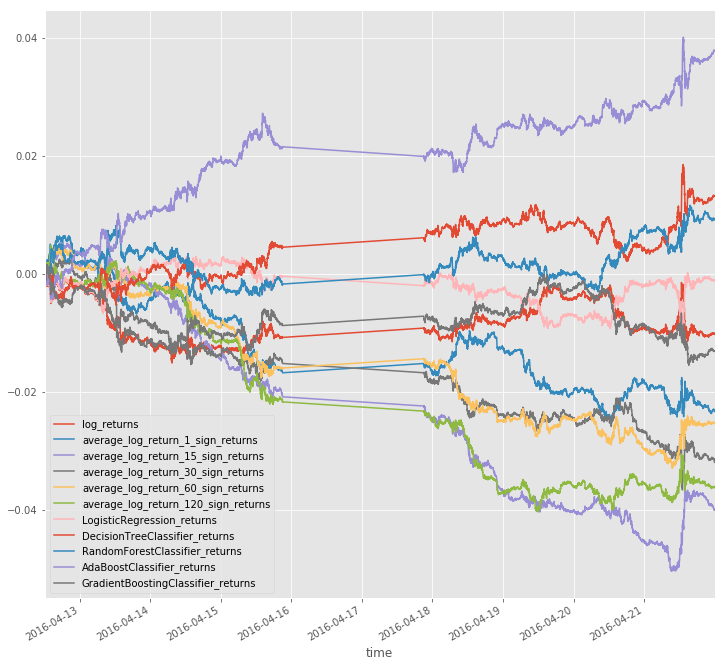

In [891]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

In [892]:
df.head(20)

volume    close     high      low     open  log_returns  \
time                                                                            
2016-04-01 01:28:00 0.029445 0.627580 0.617801 0.621085 0.617040     0.000158   
2016-04-01 01:29:00 0.020385 0.633289 0.625654 0.631231 0.627141     0.000114   
2016-04-01 01:30:00 0.024915 0.624067 0.620419 0.624173 0.630654    -0.000185   
2016-04-01 01:31:00 0.026048 0.634607 0.624782 0.625496 0.621432     0.000211   
2016-04-01 01:32:00 0.013590 0.629337 0.622600 0.632113 0.632850    -0.000105   
2016-04-01 01:33:00 0.015855 0.628898 0.623909 0.630790 0.626702    -0.000009   
2016-04-01 01:34:00 0.013590 0.636364 0.624782 0.630348 0.628898     0.000149   
2016-04-01 01:35:00 0.004530 0.637242 0.626527 0.638288 0.634168     0.000018   
2016-04-01 01:36:00 0.007928 0.631533 0.624782 0.634318 0.635046    -0.000114   
2016-04-01 01:37:00 0.006795 0.622310 0.618237 0.625055 0.628458    -0.000185   
2016-04-01 01:38:00 0.003398 0.617479 0.609511 0.620203 0.619675    -0.000097   
2016-04-01 01:39:00 0.006795 0.617040 0.605585 0.615792 0.614844    -0.000009   
2016-04-01 01:40:00 0.004530 0.624067 0.612565 0.621085 0.617040     0.000141   
2016-04-01 01:41:00 0.003398 0.627580 0.616928 0.628584 0.624506     0.000070   
2016-04-01 01:42:00 0.002265 0.625823 0.614747 0.627702 0.624945    -0.000035   
2016-04-01 01:43:00 0.006795 0.624067 0.615183 0.626378 0.623628    -0.000035   
2016-04-01 01:44:00 0.007928 0.620114 0.613874 0.622850 0.621871    -0.000079   
2016-04-01 01:45:00 0.015855 0.626702 0.615183 0.620644 0.617479     0.000132   
2016-04-01 01:46:00 0.048698 0.624945 0.616928 0.621526 0.624506    -0.000035   
2016-04-01 01:47:00 0.010193 0.623188 0.613002 0.624173 0.622310    -0.000035   

                     ari_returns  log_returns_shifted  target_label_direction  \
time                                                                            
2016-04-01 01:28:00     0.000158             0.000114                1.000000   
2016-04-01 01:29:00     0.000114            -0.000185                1.000000   
2016-04-01 01:30:00    -0.000185             0.000211                0.000000   
2016-04-01 01:31:00     0.000211            -0.000105                1.000000   
2016-04-01 01:32:00    -0.000105            -0.000009                0.000000   
2016-04-01 01:33:00    -0.000009             0.000149                0.000000   
2016-04-01 01:34:00     0.000149             0.000018                1.000000   
2016-04-01 01:35:00     0.000018            -0.000114                1.000000   
2016-04-01 01:36:00    -0.000114            -0.000185                0.000000   
2016-04-01 01:37:00    -0.000185            -0.000097                0.000000   
2016-04-01 01:38:00    -0.000097            -0.000009                0.000000   
2016-04-01 01:39:00    -0.000009             0.000141                0.000000   
2016-04-01 01:40:00     0.000141             0.000070                1.000000   
2016-04-01 01:41:00     0.000070            -0.000035                1.000000   
2016-04-01 01:42:00    -0.000035            -0.000035                0.000000   
2016-04-01 01:43:00    -0.000035            -0.000079                0.000000   
2016-04-01 01:44:00    -0.000079             0.000132                0.000000   
2016-04-01 01:45:00     0.000132            -0.000035                1.000000   
2016-04-01 01:46:00    -0.000035            -0.000035                0.000000   
2016-04-01 01:47:00    -0.000035             0.000035                0.000000   

                     target_label_direction_shifted       ADX      ADXR  \
time                                                                      
2016-04-01 01:28:00                        1.000000 36.292178 34.759302   
2016-04-01 01:29:00                        0.000000 34.541944 33.719577   
2016-04-01 01:30:00                        1.000000 32.282816 32.521983   
2016-04-01 01:31:00                        0.000000 30.360587 31.872147   
2016-0

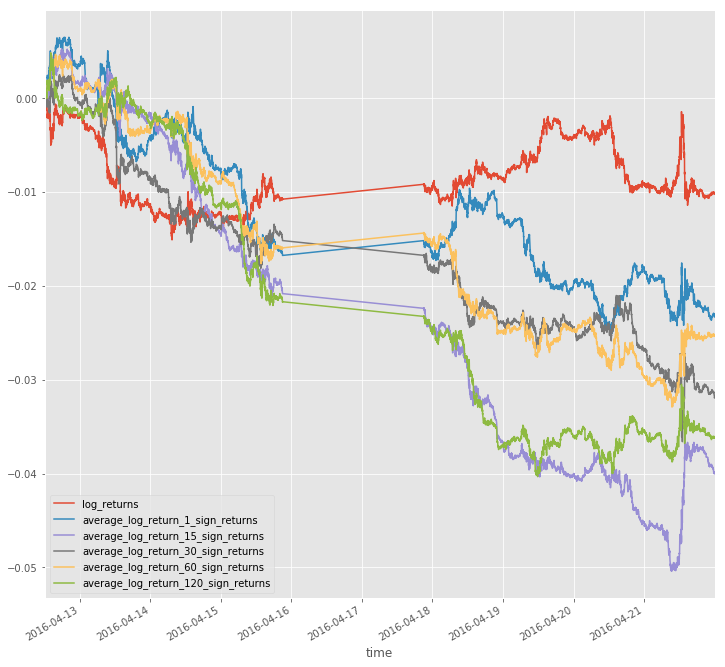

In [894]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns[:6]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

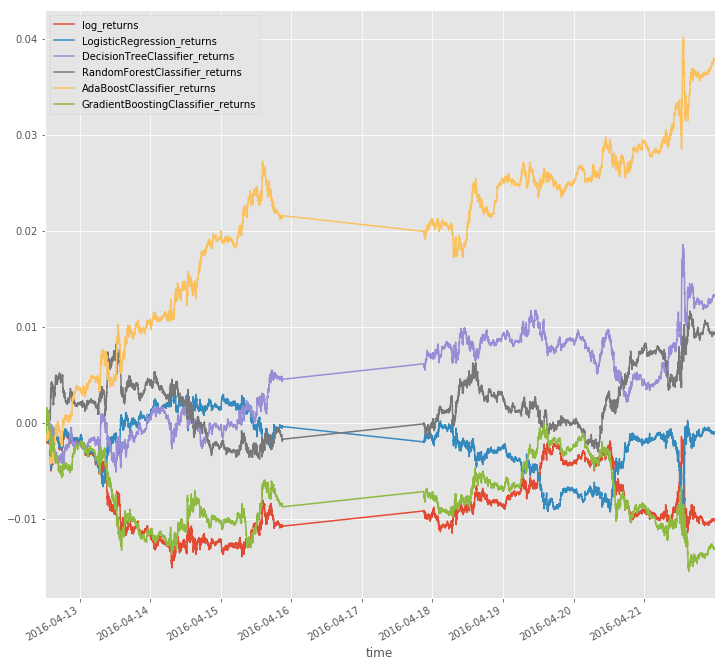

In [896]:
fig, axes = plt.subplots()
cum_returns = prediction_df[[model_returns[0]]+model_returns[6:]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')